# Introduction and Context
![partially folded paper with geometry on it](folded_paper.jpeg)

Physics simulation can involve a diversity of tools. Data science workflows - and notebooks in particular -  are a rich and widely used way to orchestrate computational tools, explore complex data spaces, and illuminate the resultant narratives. Our goal here is to provide a working example of one such workflow.

In particular,  A live Jupyter notebook is a wonderful primary interface for a simple workflow in Computational Fluid Dynamics (CFD). Beyond access to third party tools for problem specific computations and tasks it provides a central workbench to relate and process data in a familiar, consistent way using standard tools and approaches. The ability to view ensembles of physical simulations as classic dataframes allows a natural way to do the things we're used to doing with dataframes - explore the space, build models to extrapolate, and summarize and visualize.

To demonstate this we will create and explore a simple parametric design space where a few numbers will characterize the geometric design and physical context of a paper airplane. 
Using simulation data we will explore some of these parameters to understand how the way we fold and throw the airplane may affect its flight performance. We will perform these calculations and relate them to ground truth data in a resuable interactive notebook enabling us to alter and revisit aspects of the workflow as needed.

We will partition this work into three sections:

* A Workflow for a Single Simulation
 - Geometry
 - Meshing
 - Simulation
 - analysis
* Dataframe centered Simulation Ensembles
 - Dataframes
 - Computation
 - Persistence
* CFD Ensemble Centered Applications
 - Surrogate Models and Estimation
 - AeroDBs (precomputed ensembles)
 - Optimization
 
The "Colophon" section describes the specific tools we use and how they are integrated so we treat them as abtracted "black boxes" in much of the remainder, and the "Open Questions and Future Work" sectio does what it says on the tin. 

## Audience

This article is likely most useful for two types of reader:  
* comfortable with data science tools with a basic knowledge or interest in physics simulation
* physics simulation practitioners wanting to use common datascience tools in their work. 

We will treat the actual simulation as something of a "black box": to us a given simulation run is just one mapping from the input space to the output space among many. Making this simulation achieve an optimal balance between cost and accuracy (of various sorts) is of course a deep area of expertise, involves problem specific understanding, and is beyond our scope here.

## Problem Space

This is intended for ensembles of simulations which may be naturally indexed by some reasonable number of interesting input parameters and characterized with a similar sized set of interesting outputs. These  will be columns in our data frame, along with any other configuration and physical data needed to run and analyze a single simulation. While we will focus here on a structured design space, the data frame can just comprise an unstructured set of simulations so long as the output space is consistent and comparable.


We will start with non-transient problems, but this is only for initial simplicity. We can easily add time indexing to this workflow.

## Solution Space


The full solution data should be available, but our data frame will only contain specific extracted outputs and metadata.

Calculated outputs and objective functions will be available for any completed simulation and will be added to the columns of our dataframe.  Note that this includes not only physical metrics (like lift and drag) but computational ones (like run time or stability). References to the full raw solution allows us to extend and recalculate these outputs or create new ones.

It's important to note that our goal here is not to create the best possible simulation of a paper airplane's physics. It is to provide a working example of a data science centered workflow to answer a question hard enough to be interesting but no harder. We'll use the workflow to get a sense of how our design variables might effect flight performance - not apply for flight certification. Hopefully it is clear where CFD and Data Science  practitioners can adapt this example to their own interests.


# A CFD Workflow for a Single Simulation

We begin by setting up the tools and models to run a single standalone simulation and analyze its results. We will use the following python and other executables. See the `README` or the individual `lightningcatcher_*` files for installation notes.

In [1]:
# Get notebook dir on path
import pathlib, sys
sys.path.append(pathlib.Path().absolute())

# python tooling
import subprocess, sys,os, shutil, math, types
import pandas
import numpy as np
from itertools import chain

# datascience tooling:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from mpl_toolkits.mplot3d import Axes3D

# CFD tooling:
import lightningcatcher_gmsh as geometry
import lightningcatcher_su2 as cfd
import lightningcatcher_paraview as vis

## Geometry

For our example we will model a standard paper airplane as descibed [in Wikipedia](https://en.wikipedia.org/wiki/Paper_plane).

This simple design starts with folding a paper length-wise. Then we make three repeated folds of the current front wing corner in to the center line. The last of these creates the wing surface, and can be varied to provide an interesting geometric parameter for our design space. This `fuselage_radians` angle will be a primary input parameter along with the `angle of attack`: the "tilt" with which the airplane moves through the air.

![Airplane Fold Parameters](airplane_fold_diagram.png)




This `fuselage_radians` (annotated as $\phi$ on the below  diagram) controls the relative size of the wing to the central "fuselage" - if exactly $pi/16$ the wing edge will fold to the fuselage edge, otherwise allowing narrower or wider wing shapes. Note that this also affects the wing angle to the direction of travel.

![Wikipedia-sourced Plane Param](plane_param_diagram.jpg)

There are many other parameters we can explore - you will see some below where define all the model variables - but these two provide an interesting but managable design space to start with. 

Our output parameters will represent the aerodynamic performance of a given design in terms of Lift and Drag or their ratio. We compare this simulation output against experimental ground truth results below, and can also find [existing work](http://www.lactea.ufpr.br/wp-content/uploads/2018/08/On_the_Aerodynamics_of_Paper_Airplanes.pdf)


Our design space includes a lot of things we likely won't vary: the size of the paper, the final "camber" angle of the wings, etc. We encode them all in a dict, with some algorithm and visualization parameters too for convenience. You will not be misled if you think of this as a row in a dataframe, or an input point in a sample space, but we won't do so here just yet. For now, we'll use a single config for geometric, algorithmic, and visualization parameters to take a single example conf from geometry through analysis. We start with defaults for many of these things, then add what we care about here:

```
art_data = [147.25, 157, 160.25,162,177,177,183.25,185.75,189.25, 199.5]
art_y = 62
mean_distance = np.mean(art_data)
print(f"y={mean_distance/art_y}")

adf = pandas.DataFrame([{'throw_height': art_y, 'throw_distance': a} for a in art_data])

adf.to_csv('throw_data.csv', index=False)
```

In [2]:

sim = merge_dicts(
    geometry.default_config,
    {
        'project_name': "zzz",
        "fuselage_radians" : 0.6, #geometry.pi/8.0,   # wing "slope" fold angle
        "angle_of_attack" : 12.0,        # orientation to wind/movement
        "full_fold_radians" : geometry.pi,     # usually pi, unless we fold loosely
        "wing_tilt_radians" : geometry.pi/2.0,  # wing angle with fuselage
        "case_name": f"case",      # overall project name (directory)
        "body_tilt_radians" : geometry.pi/8.0,  # main fuselage fold angle
        "mach_number": 0.01,
         "base_dir": "/Users/scot/Projects/Personal/lightningcatcher/notebooks/",
        "sim_path": "/Users/scot/Projects/SU2/bin/SU2_CFD"
    })

To construct our model for a given parameter set we need only a "sheet" to start, a "fold" operation, and a "mirror" operation to save some time at the end. These should all be elementary operations in any geometry package, with a few cross products from `numpy`. We'll keep the Constructive Geometry impementation for a given tool separate to make it easy to substitute different packages for the CAD and Meshing, but the design geometry and parametrization is captured in this function, which builds the model for a parameter set:

In [3]:
# We'll make this a function - for easy variable access to config values, but also for later work
def make_airplane_model(config):
    
    # initialize the project, set camera view, and create the sheet of paper:
    c = types.SimpleNamespace(**config)
    geometry.initialize() #case_name)
    geometry.set_camera(c.camX, c.camY, 
                        c.camZ, c.camZoom, c.camZoom, c.camZoom,
                        c.camOffsetX, c.camOffsetY, c.camOffsetZ)
    
    # define points & angles from the above diagram, starting with corners of the paper
    c1,c2,c3,c4 = ( [0.0, 0.0, 0.0],
                    [0.0, 0.0, c.paper_size_z],
                    [c.paper_size_x, 0.0,  c.paper_size_z],
                    [c.paper_size_x, 0.0, 0.0])
    fold_val = c.paper_size_x*math.tan(geometry.pi/8.0)
    fixed_intercept = [c.paper_size_x, 0.0, fold_val] # c.paper_size_x*math.sin(gmsh.pi/8.0), 0.0]
    intercept = [c.paper_size_x, 0.0, c.paper_size_z*math.sin(c.fuselage_radians)]
    origin = [0.0, 0.0, 0.0]
    first_fold_point = [c.paper_size_z, 0.0,c.paper_size_z]
    sheet=geometry.make_sheet(c1,c2,c3,c4, c.paper_thickness)
    
    # fold the sheet into the airplane:
    # two folds from the nose, then the final fold forms the wing
    fold1 = geometry.fold(sheet, origin, first_fold_point, c2,c.full_fold_radians)
    fold2 = geometry.fold(fold1, origin,fixed_intercept, c2, c.full_fold_radians)  
    half = geometry.fold(fold2, origin,intercept,c2, c.wing_tilt_radians)
    
    # tilt a little for the "v" of the fusesage, then mirror.
    rhalf = geometry.fold(half, origin,c4, c2, c.body_tilt_radians)
    lhalf = geometry.copy(rhalf)
    geometry.mirror(lhalf, 0, 1,0, 0)
    
    # merge all the parts of the shape, remove internal surfaces, return model:
    geometry.synchronize()
    thing, lhb = geometry.fuse(rhalf, lhalf)
    config['geometry_index'] = thing
    return config

def merge_dicts(d1,d2):
    return dict(chain(d1.items(), d2.items()))

We can take a look at our model before proceeding, just using `gmsh` itself. This is a nice way to dial in our model before proceeding, since we can change any of the parameters easily when we call it. It's very powerful to explore changes to the mesh interactively then set the resulting parameters in our config above - try running with `interactive=True`.

In [4]:
examples = []
example_geometries = [geometry.pi/x for x in [22.0, 8.0, 4.0] ]
for i in range(3):
    c = merge_dicts(
        sim, 
        dict(
            camX=-60.0,camY=0.0,camZ=-30.0,camZoom=1.5, camOffsetX=-0.0, meshsize_large=3.0,
            fuselage_radians=example_geometries[i], define_surface_groups=False,
            case_name=f"{sim['project_name']}-{i:0>3}"
        ))
    c = make_airplane_model(c)
    geometry.save_mesh(c,None, geometry.image_filename(c))
    examples.append(c)

Creating project dir: `zzz`
None


![Three design sample points](three_geo.png)

That looks good enough for now. Note we're leaving the paper unrealistically thick here. Further, this diagram makes clear that other geometric parameters - the angle of the fuselage "v" itself, for example - likely have significant aerodynamic impact.

For now though, let's sprint to trying to get some aero modelling done!

##  Meshing

We do only simplistic of meshing here.  This keeps the geometry very simple and leaves us with a great example of using this approach to improve our models in a later article. Since we're not tuning anything, we just need to tell it to do the meshing by setting `do_meshing=True`:

In [5]:
e = examples[1]
e = make_airplane_model(e)
e = geometry.add_mesh(e)
geometry.save_mesh(e,e['meshpath'], e['imagepath'])
print(e['imagepath'])


zzz/zzz-001.jpg


![Meshed geometry view](meshed.jpg)

##  Simple Simulation - 3D flow in air at low velocity
We're ready to run a single simulation of this simple model. Beyond the raw solution flow data, we'll extract a few global output variables of interest.

In [6]:
e = cfd.run_simulation(e, do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'])


## Analysis of a single simulation run

We ran our single simulation, but don't have much to look at yet. Let's look into how we can take a look at our results - numerically and visually.

#### Extract per-surface and global objective function values

Note that we update the state dict (row in our dataframe) for each simulation with resultant output variables, so we have some output global data already available to us there. We'll look at the Aerodynamic Efficiency as a way to quantify "how good" a given design is - simply the ratio of Lift to Drag, which we'll calculate directly to verify:

$$ \mathit{Aero\ efficiency} = \frac{\mathit{Lift}}{\mathit{Drag}} = \frac{\mathit{Lift\ Coefficient}}{\mathit{Drag\ Coefficient}}$$

In [7]:
e['lift_coeff']/e['drag_coeff'], e['eff_coeff']

(3.10790172039718, 3.107901721)

#### Visualize single flow in `matplotlib`

Using standard notebook 3D plotting can get us started visualizing the results of our simulation. Let's make a 3D scatter of our airplane model with the estimated force vector at each point. In `base.cfg` we set the output path for a surface flow file. As a first step toward building our own visualizations using `matplotlib` and standard DS tools, let's open up the surface flow CSV file we generate for each sim and extract global physics data.

<IPython.core.display.Javascript object>


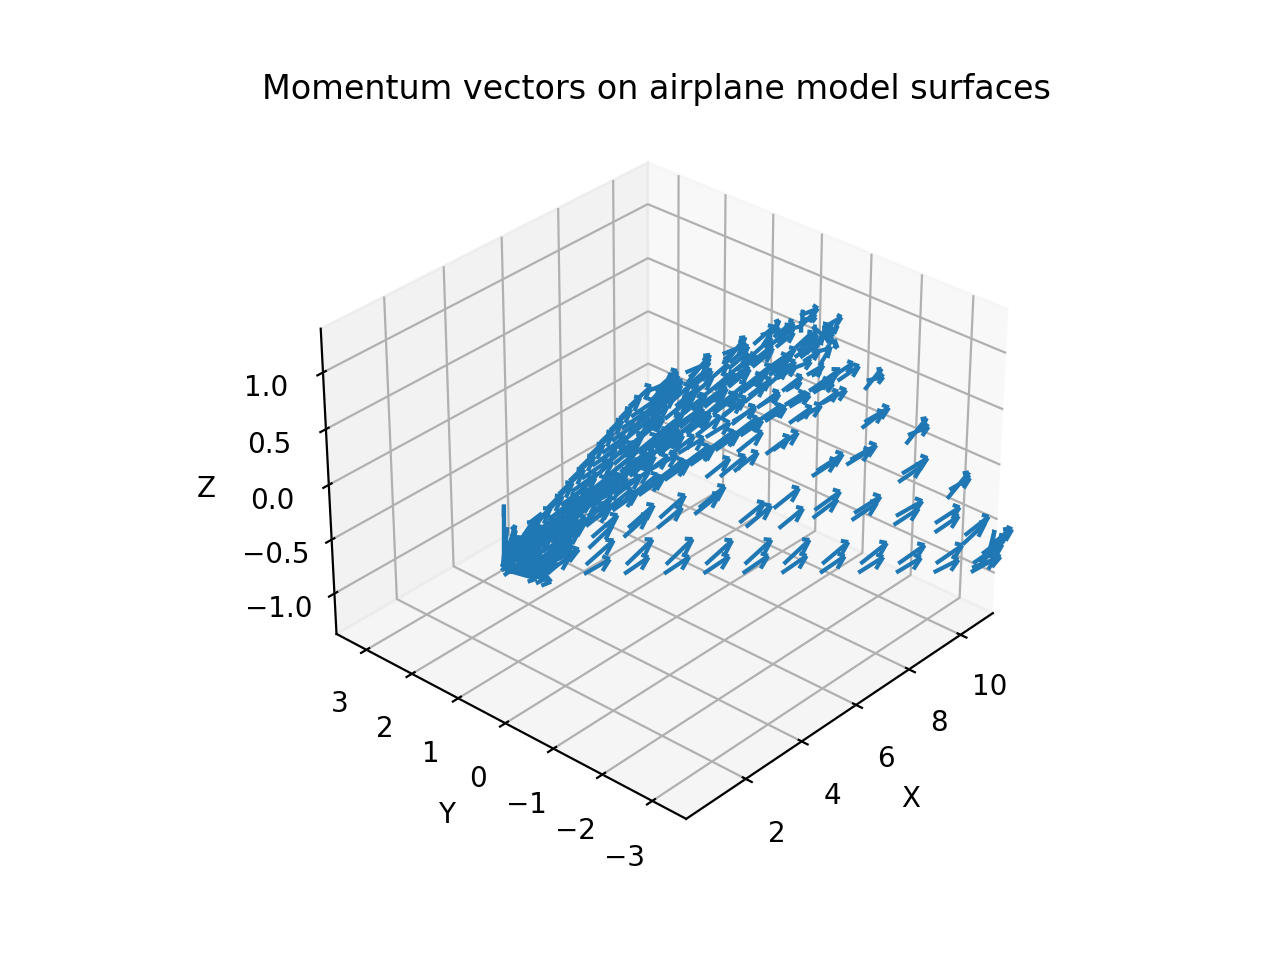

Text(0.5, 0.92, 'Momentum vectors on airplane model surfaces')

In [31]:
%matplotlib notebook
# e['surface_flow_path']='z4-017-surface_flow.csv'
sdf=pandas.read_csv( os.path.join(sim['project_name'], e['surface_flow_path']))
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.quiver(sdf['x'], sdf['y'],sdf['z'], sdf['Momentum_x'], sdf['Momentum_y'], sdf['Momentum_z'])
ax21.set_zlim([-1.5,1.5])
ax21.set_xlabel("X")
ax21.set_ylabel("Y")
ax21.set_zlabel("Z")
ax21.set_title("Momentum vectors on airplane model surfaces")
#fig2.show()
#plt.savefig("abc1/quiver.jpg")


![Force on airplane surfaces](quiver.png)

#### Visualize flow solution using external vis package
It's great to know how to build simple data representations, but for more involved analysis we'll use a purpose built tool to look at and analyze our results. Let's generate a single vis frame for one of our sample space simulations, but note that we can interact with the visualization software interactively - as with the Geometry and Meshing, this can be invaluable in trying new things and exploring.

In [9]:
e['viz_path'] = vis.visualize_case(
    e['project_name'], e,
    text=f"\"AoA: {sim['angle_of_attack']} Phi: {sim['fuselage_radians']:.2f} \"",)

#
print(e['viz_path'])

(   2.755s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fdc67f15a90): Refusing to enable OSPRay because it is not supported running in this configuration.
(   3.472s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdc80541a40): Could not determine array range.
(   3.472s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdc80541a40): Could not determine array range.


zzz/zzz-001-para.png


![Flow visualization](para.png)

#  Dataframes for CFD Ensembles

Often we're concerned with a set of related simulation runs. How should we consider this element and set? A Data Science person might like to consider a single simulation as a row in a dataframe; a CFD practitioner might think of it as an element of a DOE; a designer may just have a bunch of experimenal runs to compare and relate.

It's nice sometimes to think of CFD simulation runs as simply another mapping from an input space to an output space. We may have multiple ways to construct this mapping - for instance: different algorithmic parameters and entire algorithms, precise vs fast CFD and even non-CFD estimates, even experimental data. So rows in the input space will not have unique images in the output space unless we include the mapping used as an input. It can be useful to seperate physical inputs (air temperature), design inputs (fuselage angle), model inputs (mesh size), and algorithmic ones (CFD, linear solver), but here we want to keep things as simple as possible so we'll keep all the inputs "flat" for now.

Each row of our dataframe will contain everything needed to run and analyze a single simulation - a sample from our input space. There may be template files and mesh files which are not part of the dataframe, generally platform specific, but everything needed to generate and use these files will be columns in our dataframe.



We want a dataframe with the input part of every row populated with interesting values. Then for a given mapping we can generate the outputs. We begin by specifying all the static parameters and then varying a subset - the DOE parameters, or a sampling method in the input space, or a set of values of interest. In this case, we will vary the `fuselage_rad` alone - then with `angle of attack` in a simple grid:

We'll uses a  function to add columns to the dataframe for our project, which can involve any of:
* run CFD simulation
* extract values from previously run simulation
* apply estimations (surrogate models) to generate values
* generate sumary and visualization data

So, the return value will be available as a dataframe row.

## Build the dataframe
### First create the rows from sample points:

### Dataframe Construction

In [10]:
df = pandas.DataFrame(
    [merge_dicts(
            sim,
            {
                "case_name": f"{sim['project_name']}-{5*i+j:0>3}",
                "fuselage_radians" : 0.15 + 0.02*i,
                "angle_of_attack" : 0.0 + 3.0 * j,
             })
     for i in range(5) for j in range(5)])

### Next run simulations and add columns for extracted output
Now we'll add actual models, config, and simulation results to each row. Here we do it all at once with a the helper function function which composes our geometry, meshing, and simulation steps:

Now we'll create a convenience function to wrap up all the steps in creating, running, and processing the output of a single simulation. This composed function will then be easy to apply to the sample points in our input - taking rows in our dataframe, running simulations, and extracting the results.

In [11]:
save_all = lambda e: geometry.save_mesh(e,e['meshpath'], geometry.image_filename(e))
run_project = lambda sim_project: \
    cfd.run_simulation(
        save_all(
            geometry.add_mesh(
                make_airplane_model(sim_project))),
        do_extract=['eff_coeff','momentum_z'])
    

In [12]:
df = pandas.DataFrame(
    [run_project(row) 
     for row in df.to_dict(orient='records')])

# Add a secondary derived output variable:
df['aoa_rads'] = df.apply(lambda r:  np.deg2rad(r['angle_of_attack']), axis=1)

### an option to [un]serialize here...

In [13]:
df.to_csv(f"{sim['project_name']}/{sim['project_name']}_df.csv")

In [ ]:
df = pandas.read_csv(f"{sim['project_name']}/{sim['project_name']}_df.csv")

Note that if you want to add some variables to extract after running the simulations, your dataframe has everything you need:

In [14]:
df = pandas.DataFrame(
    [cfd.extract_simulation_values(row, extracts=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'])
     for row in df.to_dict(orient='records')])

So we can do the usual things to explore this space. As a two-dimensional response surface, we can plot this as something like a "carpet plot" with our two parameters against Lift (plotted as height) and Drag (plotted as color).

<IPython.core.display.Javascript object>


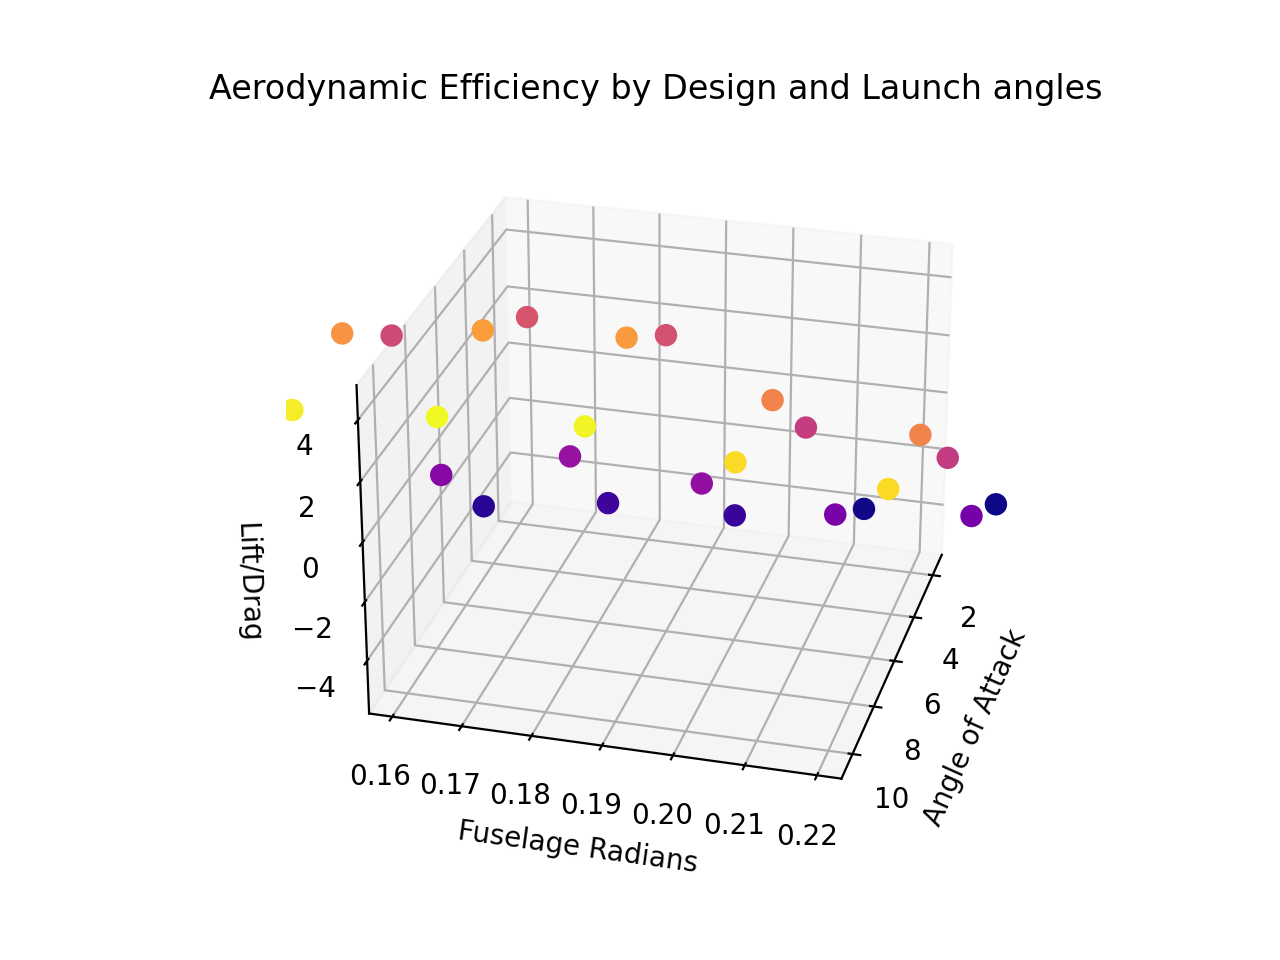

In [16]:
%matplotlib notebook
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.scatter3D(df['angle_of_attack'], df['fuselage_radians'],df['eff_coeff'], 
               s=50, alpha=1.0, c=df['lift_coeff'],
               cmap='plasma')
ax21.set_xlabel('Angle of Attack')
ax21.set_ylabel('Fuselage Radians')
ax21.set_zlabel('Lift/Drag')
ax21.set_title("Aerodynamic Efficiency by Design and Launch angles")
plt.show()

![3d scatterplot of design space samples](simple_3d_scatter.png)

## More visualization

### Flow visualization for each sample point

Add visualization images to each case using an external Visualization tool:

In [17]:
df['vispath'] = df.apply(
    lambda row: vis.visualize_case(
        row['project_name'], row,
        text=f"\"AoA: {row['angle_of_attack']} Phi: {row['fuselage_radians']:.2f} \""),
    axis=1)

(   2.705s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7cd8717340): Refusing to enable OSPRay because it is not supported running in this configuration.
(   3.685s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7d2abd4270): Could not determine array range.
(   3.685s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7d2abd4270): Could not determine array range.
(   1.777s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fdb0ca3f530): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.030s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdb0ca69290): Could not determine array range.
(   2.030s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdb0ca69290): Could not determine array range.
(   1.794s) [paraview        ]    vtkPVRenderView.cxx:

(   2.050s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc99077d990): Could not determine array range.
(   2.050s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc99077d990): Could not determine array range.
(   1.786s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fa84f7bfaa0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.026s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fa84f8b13e0): Could not determine array range.
(   2.026s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fa84f8b13e0): Could not determine array range.
(   1.859s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fe04dfd5bb0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.110s) [paraview        ]vtkSMPVRepresentationPr:

In [22]:
# vis.html_imgtable(["two", "twelve", "22"],[df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']])
display(HTML(vis.html_imgtable(
    [f"ϕ={df.iloc[2]['fuselage_radians']:.3f}", f"ϕ={df.iloc[12]['fuselage_radians']:.3f}", f"ϕ={df.iloc[22]['fuselage_radians']:.3f}"],
    [df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']])))

ϕ=0.150,ϕ=0.190,ϕ=0.230,,,


![Three flow visualizations](three_flows.png)

### Simple animation across cases

In [ ]:
vis.animate(sim, [df.iloc[i]['vispath'] for i in [2,7,12,17,22,22,17,12,7,2]])
            
                 

![GIF animation of deisgn sweep](anim.gif)

### Persist Dataframe
We will return to this design space and problem in the "Application" sequel to this article, so it's nice to note that we can store the dataframe for direct manipulation, and it includes everything we'll need if we want to run more simulations later.

In [ ]:
df.to_csv(f"{sim['project_name']}/{sim['project_name']}_df.csv")
# df = pandas.read_csv(f"{config['project_name']}/{config['project_name']}_df.csv")

# Applications


## Simple Surrogate Models
To wrap up our example of using this dataframe centered approach to exploring a CFD design space, let's make a simple Surrogate model for our simulation and compare the resulting response surface to the actual CFD data.

<IPython.core.display.Javascript object>


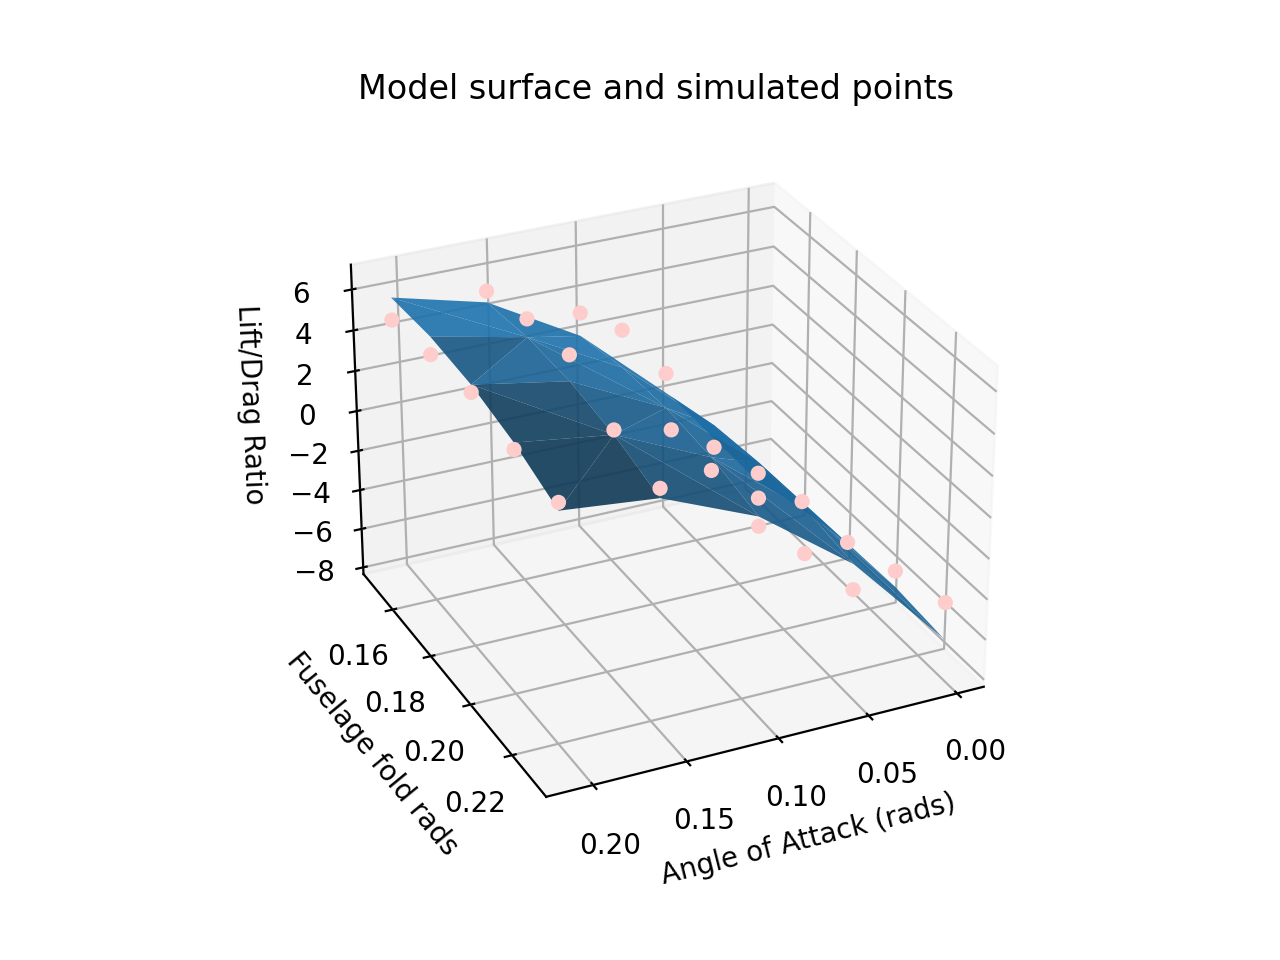

In [25]:
%matplotlib notebook
# build the transform to order-2 polynomials and fit a linear model there:
poly = PolynomialFeatures(2)
pt=poly.fit(df[['angle_of_attack', 'fuselage_radians']])
poly_model = LinearRegression()
poly_model.fit(pt.transform(df[['angle_of_attack', 'fuselage_radians']]), df['eff_coeff'])

# Plot the CFD values against the fit model:
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.plot_trisurf(df['aoa_rads'], df['fuselage_radians'],
                poly_model.predict(
                    pt.transform(df[['angle_of_attack', 'fuselage_radians']])),alpha=0.90)
ax21.scatter3D(df['aoa_rads'], df['fuselage_radians'],df['eff_coeff'] , 
               s=20, alpha=1.0, 
               c='#FCC')

# Label and Legend
ax21.set_xlabel("Angle of Attack (rads)")
ax21.set_ylabel("Fuselage fold rads")
ax21.set_zlabel("Lift/Drag Ratio")
ax21.set_title("Model surface and simulated points")
fig2.show()
fig2.savefig('carpet_plot.png')

![Carpet plot](carpet_plot.png)

## AeroDB

Precomputed databases of simulation results are useful in many ways. Later we will use one as a lookup table for Realtime Flight Simulation, but for now we simply use one to add more sample points to our our ensemble of simulations. We often want to add more sample points as we look at the results we've generated so far - hopefully we see an interesting area of the design space we'd like to "zoom in" on. We'll add the new sample points as a new dataframe and populate it, then concatenate it with the first and see if we can draw any conclusions from the overall dataset.

In [ ]:
zoomed_params = [geometry.pi/x for x in [15.5, 15.75,16.0,16.25,16.5]]
df2 = pandas.DataFrame(
    [merge_dicts(
            sim,
            {
                "case_name": f"{sim['project_name']}_zoom-{5*i+j:0>3}",
                "fuselage_radians" : zoomed_params[i],
                "angle_of_attack" : 0.0 + 3.0 * j
             })
        
    for i in range(5) for j in range(5)])

df2 = pandas.DataFrame(
    [f(row) for row in df2.to_dict(orient='records')])

In [ ]:

df2 = pandas.DataFrame(
    [cfd.extract_simulation_values(row, extracts=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'])
     for row in df2.to_dict(orient='records')])
#df2

In [ ]:
df = pandas.concat([df,df2],axis=0)

%matplotlib notebook
fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d', azim=20)
ax4.scatter3D(df['angle_of_attack'], df['fuselage_radians'],df['eff_coeff'], 
               s=50, alpha=1.0, c=df['lift_coeff'],
               cmap='plasma')
ax4.set_xlabel('Angle of Attack')
ax4.set_ylabel('Fuselage Radians')
ax4.set_zlabel('Lift/Drag')

At this point, we have a dataframe with all the parameters and simulation outputs as rows. 
Let's add a Angle of Attack in Radians to make it easier to relate to our fold.
Here we pull some interesting values out for a specific value of our Angle of Attack by way of example:

In [ ]:
df[df.angle_of_attack==6][['angle_of_attack', 'aoa_rads', 'fuselage_radians', 'eff_coeff','case_name']]\
    .sort_values(by=['fuselage_radians'])


# Design Optimization

This is all fun, but we haven't answered our question. How should we make that last fold on a "dart" style paper airplane?

What does that even mean. The optimal fold will be corellated with the throw angle (angle of attack) since the angle of the wing means that if thrown parallel to the baseline of the fuselage, the wing will be pointing down and generating negative lift. We calculated for a rangle of throw angles, and don't know what people will actually do, so we'll just average across those and find the best `fuselage_angle` for the resulting one dimensional optimization.

### Simple averaging

We assume a uniform distribution of the release angle (and hence Angle of Attack). This is likely unrealistic, but it means we can just take a simple average across that axis to yield a simple function of the fold angle:

In [41]:
avg_aoa=df.groupby('fuselage_radians')
# avg_aoa.max()['eff_coeff']
aoa=list(avg_aoa.indices.keys())

Note that if we weight our throw angles to something more realistic we get something fairly close to the experimental values from the above paper, which is nice:

### Experimental Ground Truth Data
It's always nice to compare predicted results to real-world experimental data. In this case, we applied the "Seventh Grader Throwing Paper Airplanes Down The Hall" protocol and extracted ground-truth results with a tape measure. We can load external data in as a data frame and relate it to our simulation data easily.

In [51]:
ground_truth = pandas.read_csv("throw_data.csv")
ground_truth_aero_eff = ground_truth['throw_distance'].mean()/ground_truth['throw_height'].mean()

<IPython.core.display.Javascript object>


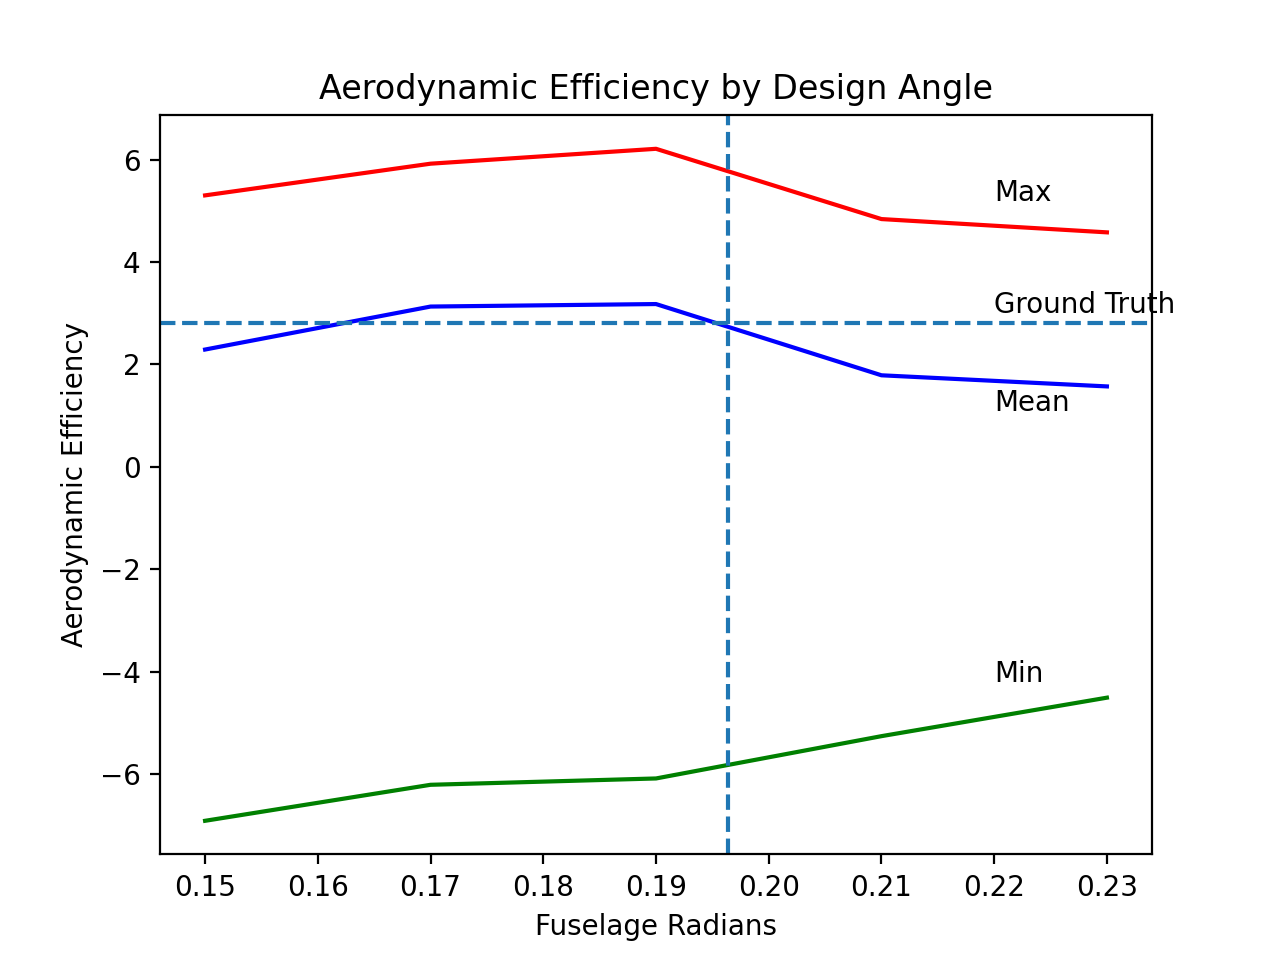

In [64]:
fig3 = plt.figure()
plt.plot(aoa, avg_aoa.max()['eff_coeff'],c='red')
plt.plot(aoa, avg_aoa.min()['eff_coeff'],c='green')
plt.plot(aoa, avg_aoa.apply(lambda x: np.average(x['eff_coeff'],weights=[0.1,0.1,0.4,0.2,0.2])) ,c='blue')
plt.axvline(x=geometry.pi/16.0,ls='--')
plt.axhline(y=ground_truth_aero_eff, ls='--')
plt.ylabel("Aerodynamic Efficiency")
plt.xlabel("Fuselage Radians")
plt.text(0.22, 3, "Ground Truth")
plt.text(0.22, 5.2, "Max")
plt.text(0.22, 1.1, "Mean")
plt.text(0.22, -4.2, "Min")
plt.title("Aerodynamic Efficiency by Design Angle")
fig3.show()
#fig3.savefig('eff.png')


This would seem to suggest that folding the wings a little past the fuselage line, rather than the traditional 'dart' fold of $/pi / 16$, is optimal. Not too far though, or the added drag reduces the efficiency. Note however that we're assuming a lot since we don't estimate right on that point. Let's zoom in and add some granularity closer to that critical point:

### Integrate out the fold angle instead - find best launch angle

Taking another literal perspective, we can integrate out the design parameter and take a guess that the optimal angle to throw our paper airplane is around $9^{\circ}$

<IPython.core.display.Javascript object>


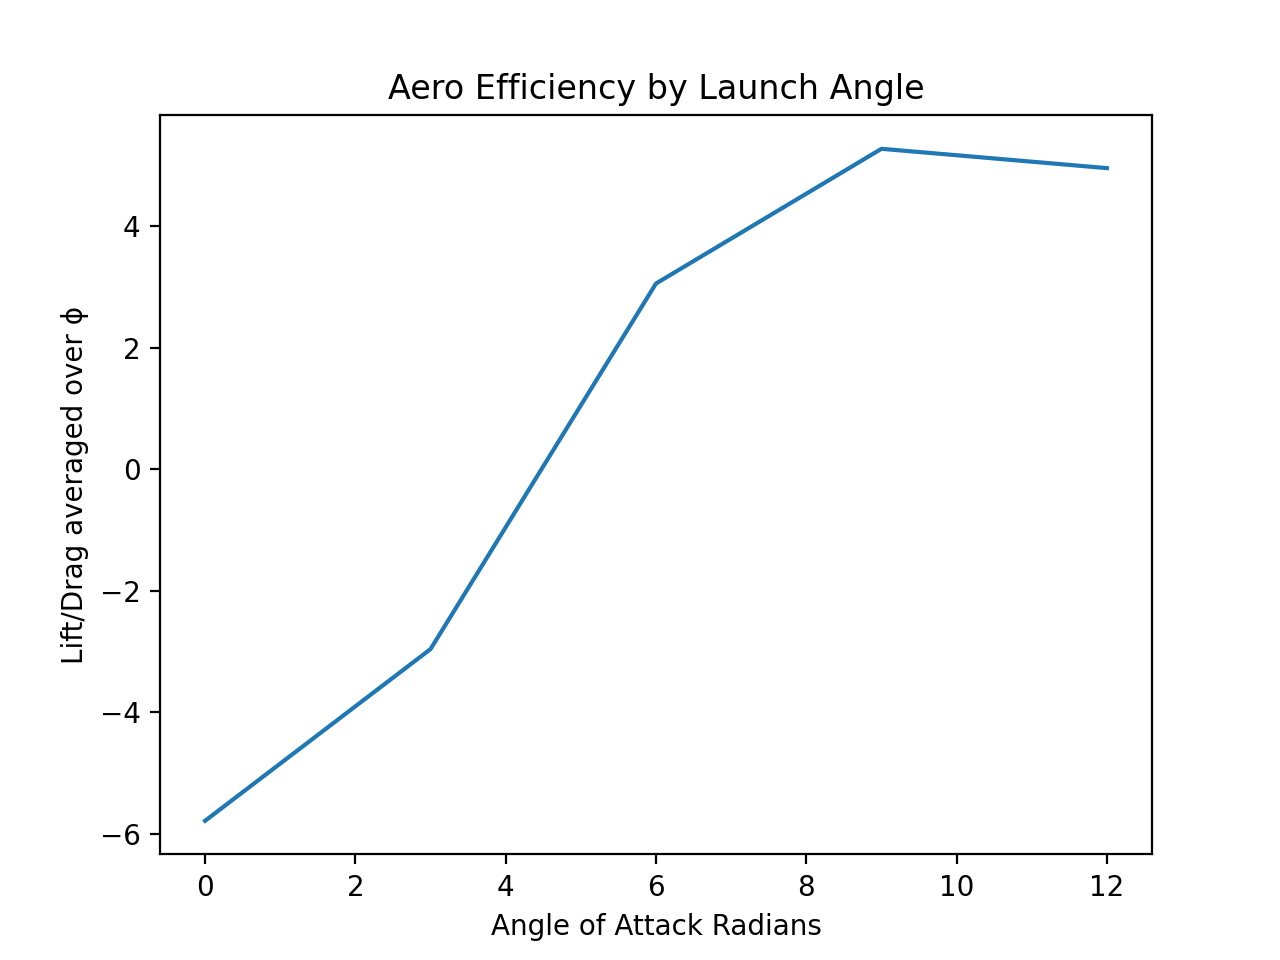

/var/folders/ty/h70sdx715cl5sdlg578tl3mh0000gn/T/ipykernel_78674/2113602864.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(df.groupby('angle_of_attack').mean()['eff_coeff'])


In [27]:
fig4=plt.figure()
plt.plot(df.groupby('angle_of_attack').mean()['eff_coeff'])
plt.xlabel("Angle of Attack Radians")
plt.ylabel("Lift/Drag averaged over ϕ")
plt.title("Aero Efficiency by Launch Angle")
fig4.show()
fig4.savefig('aoa.png')

![Angle of Attack](aoa.png)

# Results

## Do our CFD results seem reasonable?

## Does our optimization seem reasonable?

## How does clever optimization compare to a grid search?

# Open Questions and Next Steps

* Try running the `single_simulation` examples above with `interactive=True`. This will bring up `gmsh` or `paraview` (resp.) to let you move around camera angles and play with parameters, and is a wonderful exploratory mode to work in.
* What is going on with the dip in aerodynamic efficacy as the wing goes just past the exact edge of the fuselage (at $pi/32$). The sharp dip suggests something interesting - very likely, a bug in our geometry code; most likely, the naively simple simulation approach creating unphysical behaviors; or least likely, an actual critical point of some kind in the physics. 

* Should the angle of attack be normalized to the fold angle, so the wing is always at $0^{\circ}$?
* Optimization tools (Dakota, matlab, etc)
* CFD tooling
  * cfd params
  * mesh improvements
  * other CFD platforms
* problem refinement
* more parameter dimensions
* V & V

Now that we can see the general response surface, it would make sense to delve into how to run our simulation enemble more efficiently. We might use "Total Run Time" or something like convergence to generate a response surface while we vary things like mesh size or other alogorithmic parameters. We also can see it would be interesting to explore a larger patch of the `(AoA, FuselageAngle)` space. 

That means we're at a good point to end this notebook - we are exploring properties of the space using dataframes in a notebook in a way that faciliates ensemble thinking. In later notebooks, we'll look at using this ability for a range of applications and modelling improvements.




## simulation optimization

### variable mesh size and granularity

### other algorithmic parameters

### 

## design optimization

What is an interesting AoA to optimize along?

What are useful physical parameters?

Do our result make physical sense?

How should we define fitness?

How should we optimize fitness with our single variable?

Dakota Project

# Colophon


## Workbench - which tools will we use?

We begin using Open Source tools anyone can run on a personal computer and develop a workbench which will allow later exploration of more aggressive (and non-free in all senses) environments and tools.

Readers hailing from the systems side will note that we use shell and file interfaces in some places a cleaner direct API could be used. This is intentional, but not a requirement. It's useful because a number of simulation tools tend to take this configuration file approach and because it makes it's easier to, for example, pull a directory of image files into a movie with `ffmpeg` than to sort out a live interface for doing so. It also makes it easy to decouple components - we try to use light interfaces, so switching CFD engines or visualization should be mostly independent of the high level workflow. It is certainly possible to use clean/direct APIs when available, as we do for interacting with constructive solid geometry for example.

Fundamentally we want to work with Python Notebooks as a way to elegantly tie together multiple tools and platforms into coherent workflows, orchestrate computation, and analyze results. So will prefer tools that best allow this.

## Dataframes and ML
We want to have a familiar way to work with arrays of data and tools for processing them.

A primary goal here is to treat the exploration of a design space as simply mapping problem parameters to objective functions. That is, we'd like to take some geometry and simulation configuration values (input vector) and map them to some estimated physical/computational results (output vector). Note that this is classic Data Science, and so we'd like to keep a DataFrame (Pandas, for now) at the center of our work.

Note that as our design spaces grow, this naturally allows parallelization. Using Spark dataframes, for example, affords scalable parallelism via drop-in replacement and less sophisticated but servicable approaches are possible on cloud platforms.

## Geometry and Meshing
We use `gmsh` for both Parametric CAD and our Meshing. The python interface makes this pleasant-ish We will explore varying geometric parameters by rebuilding geometries and then meshes for different values. We will generate `gmsh` output files as well as....

## CFD

We use SU2 for this first foray.

We plan to make versions with other free options and commercial tools.

## Analysis
We will aggregate the tabular outputs from SU2 and process them using Pandas, Numpy, and other common DS tools . Higher level analysis and visualization will be done with Paraview.

## Optimization

Given a fully populated DOEFrame we can fit a simple model and optimize that using standard tools like `scikit-learn` and similar.